<a href="https://colab.research.google.com/github/jakinng/A-PINN/blob/main/turbulence_DNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install netCDF4
# import netCDF4 as nc

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 77, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
  File "/usr/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_

ModuleNotFoundError: No module named 'netCDF4'

In [ ]:
# @title Turbulence Code
# Adapted from https://twitter.com/CFDonia/status/1659560884769832961/photo/1
# and https://marinlauber.github.io/2D-Turbulence/

# Dependencies for generating turbulence
import math
# import numpy as np
import time
import jax.numpy as jnp
import jax
# import pandas as pd
import matplotlib.pyplot as plt
import os
from jax import jit

@jit
def init_domain(N, L = 2 * jnp.pi):
    # Create domain and spectral domain -- kx, ky are the wavenumbers in (discrete) Fourier domain
    x = jnp.linspace(0, L, N, endpoint=False)
    y = jnp.linspace(0, L, N, endpoint=False)
    dx = L / N
    dy = L / N
    X, Y = jnp.meshgrid(x, y)
    kx = jnp.fft.fftfreq(N, d = L / (N * 2 * jnp.pi)) # DFT sample frequencies
    ky = jnp.fft.fftfreq(N, d = L / (N * 2 * jnp.pi))
    KX, KY = jnp.meshgrid(kx, ky)
    ddx = KX * 1j
    ddy = KY * 1j
    # Spectral inverse of del^2 (Laplacian) in frequency domain, where del2 = d^2f/dx^2 + d^2f/dy^2
    # Here idel2 = 1 / ((1j * KX) ** 2 + (1j * KY) ** 2) = -1 / k2
    k2 = KX ** 2 + KY ** 2 # wave number squared
    idel2 = -1 / k2 # spectral inverse of Laplacian
    idel2 = idel2.at[0, 0].set(0) # The mode is the mean value of psi, and results in a division by zero. To avoid rounding error, explicitly set this to zero every computation.
    return KX, KY

def compute_spectrum(psihat, k2, res = 200):
    tke = jnp.real(.5 * k2 * psihat * jnp.conj(psihat))
    kmod = jnp.sqrt(k2)
    k = jnp.arange(1, psihat.shape[0] // 2 + 1, 1, dtype=jnp.float64) # nyquist limit for this grid
    E = jnp.zeros_like(k)
    dk = (jnp.max(k) - jnp.min(k)) / res

    #  binning energies with wavenumber modulus in threshold
    for i in range(len(k)):
        E = E.at[i].add(jnp.sum(tke[(kmod < k[i] + dk) & (kmod >= k[i] - dk)]))
    sum_E = jnp.sum(E)
    return k, E / sum_E

def plot_spectrum(psihat, k2, ax):
    # angle averaged Turbulent Kinetic Energy spectrum
    k, E = compute_spectrum(psihat, k2)
    ax.loglog(k, E, '-k', label = "E(k)")
    ax.set_xlabel("k")
    ax.set_ylabel("E(k)")
    ax.legend()

def plot_spectrum_omega(omega, k2, idel2, ax):
    omegahat = jnp.fft.fft2(omega)
    psihat = idel2 * omegahat
    plot_spectrum(psihat, k2, ax)

def run_turbulence():
    """
    Takes in an array of shape (N, N) and returns a zero-padded array of shape (M, M), where M = 3 * (N // 2)
    """
    @jit
    def padded(array):
        N = array.shape[0]
        padded = jnp.concatenate((array[:N//2], jnp.zeros(shape = (N // 2, N)), array[N // 2:]), axis = 0)
        padded = jnp.concatenate((padded[:, :N//2], jnp.zeros(shape = (3 * (N // 2), N // 2)), padded[:, N // 2:]), axis = 1)
        return padded

    """
    Takes in an array of shape (M, M) and returns an array of shape (N, N), where M = 3 * (N // 2)
    """
    @jit
    def unpadded(array):
        M = array.shape[0]
        index_kmax = math.ceil(M / 3)
        idx_l = index_kmax
        idx_u = 2 * index_kmax
        unpadded = jnp.concatenate((array[:idx_l], array[idx_u:]), axis = 0)
        unpadded = jnp.concatenate((unpadded[:, :idx_l], unpadded[:, idx_u:]), axis = 1)
        return unpadded

    # Initial time
    t0 = 0
    def solution(t):
        return 2 * jnp.sin(kappa * X) * jnp.sin(kappa * Y)* jnp.exp(-2 * kappa**2 * nu * t)

    def plot_data(data, x = None, y = None, title = "", show = show_plot, ax = None):
        if ax is None:
            if x is not None and y is not None:
                h = plt.pcolormesh(x, y, data, shading = "auto")
            else:
                h = plt.pcolormesh(data)
            plt.colorbar(h)
            plt.title(title)
            plt.close()
        else:
            if x is not None and y is not None:
                h = ax.pcolormesh(x, y, data, shading = "auto")
            else:
                h = ax.pcolormesh(data)
            plt.colorbar(h, ax = ax)
            ax.set_title(title)
            ax.set_aspect('equal')
        if show:
            plt.show()

    """
    Generates McWilliams vorticity field, see:
        McWilliams (1984), "The emergence of isolated coherent vortices in turbulent flow"

    The spectrum is broad banded and peaks around k0
    """
    def generate_vorticity_mcwilliams(k0 = 6):
        nk = N // 2 + 1 # wave numbers

        # generate variable
        k2 = kx[:nk]**2 + ky[:,jnp.newaxis]**2
        fk = (k2 != 0.0)

        # ensemble variance proportional to the prescribed scalar wavenumber function
        ck = jnp.zeros((N, nk))
        ck = ck.at[fk].set((jnp.sqrt(k2[fk])*(1+(k2[fk]/(k0**2))**2))**(-1))

        # Gaussian random realization for each of the Fourier components of psi
        psih = jax.random.normal(key = key, shape = (N, nk))*ck+1j*jax.random.normal(key = key, shape = (N, nk))*ck

        # ṃake sure the stream function has zero mean
        cphi = 0.65 * jnp.max(kx)
        wvx = jnp.sqrt(k2)
        filtr = jnp.exp(-23.6*(wvx-cphi)**4.)
        filtr = filtr.at[wvx<=cphi].set(1.)
        def _spec_variance(ph):
            # only half the spectrum for real ffts, needs spectral normalisation
            nx, nk = ph.shape
            ny = (nk-1)*2
            var_dens = 2 * jnp.abs(ph)**2 / (nx*ny)**2
            # only half of coefs [0] and [nx/2+1] due to symmetry in real fft2
            var_dens = var_dens.at[..., 0].divide(2.)
            var_dens = var_dens.at[...,-1].divide(2.)

            return var_dens.sum(axis=(-2,-1))
        KEaux = _spec_variance(filtr*jnp.sqrt(k2)*psih)
        psi = psih/jnp.sqrt(KEaux)

        # inverse Laplacian in k-space
        wh = k2 * psi

        # vorticity in physical space
        field = jnp.fft.irfft2(wh)
        return field

    def generate_vorticity_taylor_green(t0, show_plot):
        omega = solution(t0)
        h = plt.pcolormesh(omega)
        plt.colorbar(h)
        plt.title("Initial Vorticity")
        if show_plot:
            plt.show()
        plt.close()

        h = plt.pcolormesh(solution(t0))
        plt.colorbar(h)
        plt.title("Actual Solution")
        if show_plot:
            plt.show()
        plt.close()

        h = plt.pcolormesh(omega - solution(t0))
        plt.colorbar(h)
        plt.title("Difference")
        if show_plot:
            plt.show()
        plt.close()
        print(jnp.max(omega - solution(t0)))
        return omega

    if initial_cond == "taylor-green":
        # Taylor-Green vortex, known solution to N-S equations: https://en.wikipedia.org/wiki/Taylor%E2%80%93Green_vortex
        # Used for testing/validation of temporal accuracy of N-S equations
        omega = generate_vorticity_taylor_green(t0, show_plot)

    elif initial_cond == "mcwilliams":
        omega = generate_vorticity_mcwilliams()

    omegahat = jnp.fft.fft2(omega)
    psihat = idel2 * omegahat
    psi = jnp.fft.ifft2(psihat).real
    u_hat = ddy * psihat # hat(dpsi/dy)
    v_hat = -1 * ddx * psihat # -hat(dpsi/dx)
    u = jnp.fft.ifft2(u_hat).real
    v = jnp.fft.ifft2(v_hat).real

    ax = plt.subplot(111)
    plot_spectrum_omega(omega = omega, k2 = k2, idel2 = idel2, ax = ax)
    plt.show()

    # save x, y, time, u, v, omega, psi
    # time_array = jnp.array([t0])
    # u_array = jnp.array([u])
    # v_array = jnp.array([v])
    # omega_array = jnp.array([omega])
    # psi_array = jnp.array([psi])

    @jit
    def RK(omega0, dt):
        omegahat0 = jnp.fft.fft2(omega0)
        omegahat = omegahat0

        s = 3
        for l in range(s, 0, -1):
            psihat = idel2 * omegahat
            psi = jnp.fft.ifft2(psihat).real
            u_hat = ddy * psihat # hat(dpsi/dy)
            v_hat = -1 * ddx * psihat # -hat(dpsi/dx)
            u = jnp.fft.ifft2(u_hat).real
            v = jnp.fft.ifft2(v_hat).real

            # Add convective/advective term
            domega_dx_hat = ddx * omegahat
            domega_dy_hat = ddy * omegahat

            # Pad before ifft2 to avoid aliasing
            padded_u = jnp.fft.ifft2(padded(u_hat)).real
            padded_v = jnp.fft.ifft2(padded(v_hat)).real
            padded_domega_dx = jnp.fft.ifft2(padded(domega_dx_hat)).real
            padded_domega_dy = jnp.fft.ifft2(padded(domega_dy_hat)).real
            convection = padded_u * padded_domega_dx + padded_v * padded_domega_dy
            convection_hat = unpadded(jnp.fft.fft2(convection)) # unpad the resulting spectrum

            # Add diffusion term
            diffusion_hat = -1 * k2 * omegahat / Re
            omegahat = omegahat0 + (-1 * convection_hat + diffusion_hat) * (dt / l)

            # Calculate next timestep
            Dc =  jnp.max(jnp.pi * ((1 + jnp.abs(u)) / dx + (1 + jnp.abs(v)) / dy)) # convective velocity scale
            Dmu = jnp.max(jnp.pi ** 2 * (dx ** (-2) + dy ** (-2)))
            dt = CFLmax / (Dc + Dmu) # adaptive timestep based on CFL number

            # plot_data(convection * dt / l, "convection")
            # plot_data(convection_hat.real * dt / l, "convectionhat")
            # if l == 1:
            #     plot_data(omega0, "Omega0")
            #     plot_data(jnp.fft.ifft2(diffusion_hat).real * dt / l, "diffusion")
            #     plot_data(solution(time + dt) - solution(time), "solution difference (want to be same as diffusion)")

        # Calculate results to return in spatial domain
        omega = jnp.fft.ifft2(omegahat).real
        psihat = idel2 * omegahat
        psi = jnp.fft.ifft2(psihat).real
        u_hat = ddy * psihat # hat(dpsi/dy)
        v_hat = -1 * ddx * psihat # -hat(dpsi/dx)
        u = jnp.fft.ifft2(u_hat).real
        v = jnp.fft.ifft2(v_hat).real
        return omega, psi, u, v, dt

    def make_arrays(omega, time, step, dt):
        omegahat = jnp.fft.fft2(omega)
        psihat = idel2 * omegahat
        psi = jnp.fft.ifft2(psihat).real
        u_hat = ddy * psihat # hat(dpsi/dy)
        v_hat = -1 * ddx * psihat # -hat(dpsi/dx)
        u = jnp.fft.ifft2(u_hat).real
        v = jnp.fft.ifft2(v_hat).real

        # save x, y, time, u, v, omega, psi
        time_array = jnp.zeros(shape = (num_steps, ))
        u_array = jnp.zeros(shape = (num_steps, N, N))
        v_array = jnp.zeros(shape = (num_steps, N, N))
        omega_array = jnp.zeros(shape = (num_steps, N, N))
        psi_array = jnp.zeros(shape = (num_steps, N, N))

        # Adaptive timestep
        if dt is None:
            Dc =  jnp.max(jnp.pi * ((1 + jnp.abs(u)) / dx + (1 + jnp.abs(v)) / dy)) # convective velocity scale
            Dmu = jnp.max(jnp.pi**2 * (dx ** (-2) + dy ** (-2)))
            dt = CFLmax / (Dc + Dmu) # adaptive timestep based on CFL number

        for i in range(0, num_steps * save_every): # the number of loops within make_arrays
            if step % save_every == 0:
                time_array = time_array.at[i].set(time)#jnp.array([t0])
                u_array = u_array.at[i, :, :].set(u)#jnp.array([u])
                v_array = v_array.at[i, :, :].set(v)#jnp.array([v])
                omega_array = omega_array.at[i, :, :].set(omega)#jnp.array([omega])
                psi_array = psi_array.at[i, :, :].set(psi)#jnp.array([psi])
#            for j in range(save_every): # save result only every 10 steps to reduce size of file
            omega, psi, u, v, dt = RK(omega, dt)
            time += dt
            step += 1 # save_every
        return time_array, u_array, v_array, omega_array, psi_array, time, step, dt, omega

    time = t0
    dt = None
    step = 0
    time_array_long = jnp.array([])
    u_array_long = jnp.empty(shape = (0, N, N))
    v_array_long = jnp.empty(shape = (0, N, N))
    omega_array_long = jnp.empty(shape = (0, N, N))
    psi_array_long = jnp.empty(shape = (0, N, N))
    with open(f"{filename}.npz", 'wb') as f:
        while time < tend:
        # while step < 100:
            print(f"{time=}")
            fig = plt.figure(figsize=[5, 5], dpi=300)
            ax = plt.subplot(221)
            plot_data(omega, x = x, y = y, title = "Vorticity", ax = ax, show = False)
            ax = plt.subplot(222)
            plot_data(psi, x = x, y = y, title = "Stream Function", ax = ax, show = False)

            if initial_cond == "taylor-green":
                ax = plt.subplot(224)
                plot_data(omega - solution(time), x = x, y = y, title = "Difference", ax = ax, show = False)
                ax = plt.subplot(223)
                plot_data(solution(time), x = x, y = y, title = "True Vorticity", ax = ax, show = False)
            elif initial_cond == "mcwilliams":
                ax = plt.subplot(224)
                plot_spectrum_omega(omega = omega, k2 = k2, idel2 = idel2, ax = ax)

            plt.suptitle(f"Time: {time:04f}")
            plt.tight_layout()
            if step % 50 == 0:
                plt.savefig(f"{filename}{step:07}.png")
            if show_plot:
                plt.show()
            plt.close()

            time_array, u_array, v_array, omega_array, psi_array, time, step, dt, omega = make_arrays(omega, time, step, dt)
            # plot_data(omega - omega_prev, f"OMEGA DIFF {i}")
            # plot_data(solution(time + dt) - solution(time), f"solution difference (want to be same as diffusion) {i}")
            # plot_data(omega - omega_prev - (solution(time + dt) - solution(time)), f"difference difference {i}")
            # plot_data(omega_prev - solution(time), f"previous time diff {i}")
            # plot_data(omega - solution(time + dt), f"next time diff {i}")
            time_array_long = jnp.concatenate([time_array_long, time_array])
            u_array_long = jnp.concatenate([u_array_long, u_array])
            v_array_long = jnp.concatenate([v_array_long, v_array])
            omega_array_long = jnp.concatenate([omega_array_long, omega_array])
            psi_array_long = jnp.concatenate([psi_array_long, psi_array])
            jnp.savez(f, time = time_array_long, u = u_array_long, v = v_array_long, omega = omega_array_long, psi = psi_array_long)

            print(f"step = {step}    time = {time}   dt = {dt}")

    # RK_jit = jax.jit(RK)
    # RK_jit(omega, dt)
    # %timeit jax.block_until_ready(RK_jit(omega, dt))

    # RK(omega, dt)
    # %timeit jax.block_until_ready(RK(omega, dt))
    print(f"{step=}, {time=}, {dt=}")

show_plot = True
Re = 2000
nu = 1 / Re
kappa = 1 # Number of vortices in each direction for Taylor-Green initial condition
### Third-order Runge-Kutta
CFLmax = jnp.sqrt(3)

jax.config.update("jax_enable_x64", True)

N = 256
L = 2 * jnp.pi  # length of x and y scales in square domain with LxL = [0, 2pi]x[0, 2pi]
seed = 1324
key = jax.random.PRNGKey(seed)
tend = 7
initial_cond = "mcwilliams"

save_every = 1
num_steps = 1
description = f"{N=}_{Re=}_{initial_cond}_{save_every=}_{num_steps=}"
cluster = False
if cluster:
    filename = f"/oak/stanford/groups/cyaolai/JakinNg/2024_03_07/{description}"
else:
    filename = f"/content/drive/MyDrive/Stanford/2024_03_07/turbulence_{description}"

start_time = time.time()
# run_turbulence()
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))
print(f"{description=}")


Training time: 0.0001


In [ ]:
# Dependencies for generating turbulence
import math
# import numpy as np
import time
import jax.numpy as jnp
import jax
# import pandas as pd
import matplotlib.pyplot as plt
import os
from jax import jit
import xarray as xr

#@title Plot Energy Spectrum
def init_turbulence_data(filename = '/content/drive/MyDrive/Stanford/FDNS Psi W_train_Re_100k.mat'):
  import numpy as np
  import h5py
  f = h5py.File(filename,'r')
  print(f)
#   for key in f.keys():
#       print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
#       print(type(f[key])) # get the object type: usually group or dataset
  #Get the HDF5 dataset; key needs to be a group name from above
  psi = np.array(f['Psi'][:])
  omega = np.array(f['W'][:])
  return psi, omega

"""
Plot energy spectrum from .mat or .nc file at time index t_idx
"""
def plot_energy_spectrum_data(filetype = "nc", t_idx = -1):
    if filetype == "nc":
        filename = '/content/drive/MyDrive/Stanford/fake_turbulence_512_'
        ds = xr.open_dataset(f"{filename}.nc")
        psi = ds.psi.isel(time = t_idx).values
        # omega = ds.vorticity.isel(time = time_index).values
    if filetype == "mat":
        filename = "/content/drive/MyDrive/Stanford/FDNS Psi W_train_Re_100k"
        psi, omega = init_turbulence_data(filename = f"{filename}.mat")
        psi = psi[:, :, t_idx]
    N = psi.shape[0]
    print(N)
    L = 2 * jnp.pi
    kx = jnp.fft.fftfreq(N, d = L / (N * 2 * jnp.pi)) # DFT sample frequencies
    ky = jnp.fft.fftfreq(N, d = L / (N * 2 * jnp.pi))
    KX, KY = jnp.meshgrid(kx, ky)
    k2 = KX ** 2 + KY ** 2 # wave number squared
    psihat = jnp.fft.fft2(psi)

    ax = plt.subplot(111)
    plot_spectrum(psihat = psihat, k2 = k2, ax = ax)
    plt.save(f"{filename}.png")
    plt.show()

plot_energy_spectrum_data(filetype = "nc")

512


NameError: name 'jnp' is not defined

<HDF5 file "FDNS Psi W_train_Re_100k.mat" (mode r)>
velocity spectrum [[4.75173714e-08 2.61920181e-07 2.18302435e-07 ... 1.18909747e-07
  2.18302435e-07 2.61920181e-07]
 [9.20955172e-08 2.70876869e-07 2.55055848e-07 ... 1.84875271e-07
  2.12781985e-07 2.92008388e-07]
 [1.66262627e-07 3.81824641e-07 3.37487568e-07 ... 1.57091042e-07
  3.03363236e-07 3.93870013e-07]
 ...
 [5.51023266e-07 6.49677020e-07 8.74335900e-07 ... 4.92220661e-07
  8.71187742e-07 6.68549312e-07]
 [1.66262627e-07 3.93870013e-07 3.03363236e-07 ... 2.26851653e-07
  3.37487568e-07 3.81824641e-07]
 [9.20955172e-08 2.92008388e-07 2.12781985e-07 ... 7.49832921e-08
  2.55055848e-07 2.70876869e-07]]


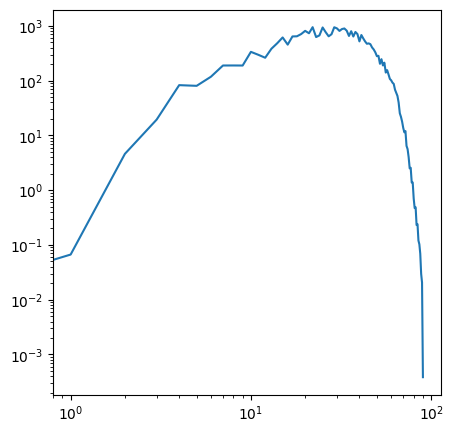

In [ ]:
import numpy as np

psi, omega = init_turbulence_data(filename = "/content/drive/MyDrive/Stanford/FDNS Psi W_train_Re_100k.mat")
t_idx = 0
omega_initial = omega[:, :, t_idx]
N_ux, N_uy = omega_initial.shape

## PLOT ENERGY SPECTRUM

## This is WRONG -- make sure omega/k is correct up to a factor of 2pi, as well as all the factors of k and multiplication and so on. this has been moved to plot_energy_spectrum
target = omega_initial
# lb = np.array([x.min(), y.min()])
# ub = np.array([x.max(), y.max()])
lb = np.array([0, 0])
ub = np.array([2 * np.pi, 2 * np.pi])
x = np.linspace(lb[0], ub[0], N_ux, endpoint = False)
y = np.linspace(lb[1], ub[1], N_uy, endpoint = False)
X, Y = np.meshgrid(x, y)

gradient = np.gradient(target, x, y)
u = gradient[0] # u = dpsi/dy
v = -gradient[1] #v = -dpsi/dx
uv_max = np.max([u, v, target])
uv_min = np.min([u, v, target])
u_hat = np.fft.fftn(u, norm = "forward")
u_hat_abs = np.abs(np.fft.fftshift(u_hat))
v_hat = np.fft.fftn(v, norm = "forward")
v_hat_abs = np.abs(np.fft.fftshift(v_hat))
timestep = np.array([N_ux, N_uy]) / (ub - lb)
freq_x = np.fft.fftshift(np.fft.fftfreq(n = N_ux, d = 1 / timestep[0])) # frequency in multiples of 1/pi cycles/second
freq_y = np.fft.fftshift(np.fft.fftfreq(n = N_uy, d = 1 / timestep[1]))
velocity_spectrum = np.square(u_hat_abs) + np.square(v_hat_abs)
print("velocity spectrum", velocity_spectrum)

# print(np.max(np.sqrt(v_hat.real**2 + v_hat.imag**2)))
E_k = {} # key: k, value: sum_{|k| = k} |\hat{u}_k|^2
# E = {'E' : np.array([]), 'k' : np.array([])}
for x_n in range(len(freq_x)):
    for y_n in range(len(freq_y)):
        k_x = freq_x[x_n]
        k_y = freq_y[y_n]
        k = 1 * ((np.sqrt(k_x**2 + k_y**2) * 2 * np.pi) // 1) # make sure the 2 * np.pi and stuff is correct
        if k in E_k:
            E_k[k] += velocity_spectrum[x_n, y_n] * k ** 2
        else:
            E_k[k] = velocity_spectrum[x_n, y_n] * k ** 2

        # E['k'] = np.append(E['k'], k)
        # E['E'] = np.append(E['E'], velocity_spectrum[x_n, y_n])
        # E['E'] = np.append(E['E'], np.abs(u_hat[x_n, y_n])**2 + np.abs(v_hat[x_n, y_n])**2) # check if this is right?
fig = plt.figure(figsize = [5, 5])
ax = plt.subplot(111)
ax.set_yscale('log')
ax.set_xscale('log')
ax.plot(*zip(*sorted(E_k.items())))

In [ ]:
#@title Create .mp4 from .npz turbulence file

# import netCDF4 as nc
# import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import os
import numpy as np
import argparse

# parser = argparse.ArgumentParser()
# parser.add_argument("-f", "--Filename", help = "Filename to read turbulence data from, such as turbulence.nc")
# args = parser.parse_args()
# if args.Filename:
#     filename = args.Filename
# else:
filename = "N=512_Re=2000_mcwilliams_save_every=16000_num_steps=1.npz"

with open(filename, "rb") as f:
    variables = np.load(f) #, allow_pickle = True)
    time = variables['time']
    omega = variables['omega']
    psi = variables['psi']
    description = "N=512_Re=2000_mcwilliams_save_every=16000_num_steps=1" #filename[:-3]

    t_max = 40
    N = omega.shape[0]
    L = 2 * math.pi  # length of x and y scales in square domain with LxL = [0, 2pi]x[0, 2pi]
    # Create domain
    x = np.linspace(0, L, N, endpoint=False)
    y = np.linspace(0, L, N, endpoint=False)
    vmax = np.max(omega)
    vmin = np.min(omega)

    def show_vorticity():
        for t in range(t_max):
            if t % 10 == 0:
                plt.axis('square')
                plt.pcolormesh(x, y, omega[t,:,:], vmax = vmax, vmin = vmin)
                plt.savefig(f"{description}_{t:05}.png")
                plt.show(block=False)
                plt.pause(0.1)

    def save_mp4():
        fig = plt.figure()
        ax = fig.add_subplot(111)
        pcolor = ax.pcolormesh(omega[0,:,:])#x, y, vorticity[:,:,0])#, vmax = vmax, vmin = vmin)
        cbar = plt.colorbar(pcolor, ax = ax)
        plt.axis('square')

        plot_every = 20
        save = False
        def animate(t, omega):#, x, y):
            print(f"{t=}")
            idx = t * plot_every
            data = omega[idx, :, :]
            pcolor.set_array(data)
            pcolor.set_clim(np.min(data), np.max(data))

            if save:
                plt.savefig(f"{description}_{idx:05}.png")

        frames = t_max // plot_every
        print(f"{frames=}")

        anim = animation.FuncAnimation(fig, lambda k: animate(k, omega), frames = frames, repeat=False)
                                    #, init_func = init)
        plt.show()
        FFwriter = animation.FFMpegWriter(fps = frames // 30)
        anim_filename = f"{description}.mp4"
        anim.save(filename = anim_filename, writer = FFwriter, dpi = 300)
        print(f"open {anim_filename}")

    def plot_t():
        Re = 2000
        nu = 1 / Re

        for i in [0, 21, 32, 53, 64, 86, 127]:
            v_over_time = omega[i, 32, :]
            plt.plot(time, v_over_time, label = "DNS decay over time")
            plt.plot(time, v_over_time[0] * np.exp(-2 * nu * time), label = "Solution for decay over time")
            plt.legend()
            plt.show()


save_mp4()
# plot_t()

#@title Create .mp4 from .npz turbulence file

# import netCDF4 as nc
# import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import os
import numpy as np
import argparse

# parser = argparse.ArgumentParser()
# parser.add_argument("-f", "--Filename", help = "Filename to read turbulence data from, such as turbulence.nc")
# args = parser.parse_args()
# if args.Filename:
#     filename = args.Filename
# else:
#filename = "N=256_Re=2000_taylor-green_save_every=30000_num_steps=20_new.npz"
filename = "N=512_Re=2000_mcwilliams_save_every=16000_num_steps=1.npz"

with open(filename, "rb") as f:
    variables = np.load(f) #, allow_pickle = True)
    time = variables['time']
#    omega = variables['omega']
    psi = variables['psi']
    description = "N=512_Re=2000_mcwilliams_save_every=16000_num_steps=1" #filename[:-3]

    t_max = 7
    N = psi.shape[-1]
    L = 2 * math.pi  # length of x and y scales in square domain with LxL = [0, 2pi]x[0, 2pi]
    # Create domain
    x = np.linspace(0, L, N, endpoint=False)
    y = np.linspace(0, L, N, endpoint=False)
    vmax = np.max(psi)
    vmin = np.min(psi)

    def show_vorticity():
        for t in range(t_max):
            if t % 1 == 0:
                plt.pcolormesh(x, y, omega[t,:,:], vmax = vmax, vmin = vmin)
                plt.axis('square')
                plt.savefig(f"{description}_{t:05}.png")
                plt.show(block=False)
                plt.pause(1)

    # angle averaged Turbulent Kinetic Energy spectrum
    def compute_spectrum(psihat, k2, res = 200):
        tke = np.real(.5 * k2 * psihat * np.conj(psihat))
        kmod = np.sqrt(k2)
        k = np.arange(1, psihat.shape[0] // 2 + 1, 1, dtype=np.float64) # nyquist limit for this grid
        E = np.zeros_like(k)
        dk = (np.max(k) - np.min(k)) / res

        #  binning energies with wavenumber modulus in threshold
        for i in range(len(k)):
#            E = E.at[i].add(np.sum(tke[(kmod < k[i] + dk) & (kmod >= k[i] - dk)]))
            E[i] = E[i] + np.sum(tke[(kmod < k[i] + dk) & (kmod >= k[i] - dk)])
        sum_E = np.sum(E)
        return k, E / sum_E

    def save_mp4(psi):
        kx = np.fft.fftfreq(N, d = L / (N * 2 * np.pi)) # DFT sample frequencies
        ky = np.fft.fftfreq(N, d = L / (N * 2 * np.pi))
        KX, KY = np.meshgrid(kx, ky)
        k2 = KX ** 2 + KY ** 2 # wave number squared
        psihat = np.fft.fft2(psi[0])

        fig = plt.figure(figsize = [4, 2], dpi = 300)
        ax = plt.subplot(122)
        k, E = compute_spectrum(psihat, k2)
        line, = ax.loglog(k, E, '-k', label = "E(k)")
        ax.set_xlabel("k")
        ax.set_ylabel("E(k)")

        ax = fig.add_subplot(121)
        pcolor = ax.pcolormesh(x, y, psi[0,:,:], cmap = 'jet')#x, y, vorticity[:,:,0])#, vmax = vmax, vmin = vmin)
        cbar = plt.colorbar(pcolor, ax = ax)
        plt.axis('square')

        fig.suptitle(f"Stream function at time {time[0]:0.2f}")

        plot_every = 1
        save = False
        def animate(t, psi):#, x, y):
            print(f"{t=}")
            idx = t * plot_every
            data = psi[idx, :, :]
            pcolor.set_array(data)
            pcolor.set_clim(np.min(data), np.max(data))

            psihat = np.fft.fft2(psi[t])
            k, E = compute_spectrum(psihat, k2)
            line.set_data(k, E)
            fig.suptitle(f"Stream function at time {time[t]:0.2f}")

            if save:
                plt.savefig(f"{description}_{idx:05}.png")
            plt.tight_layout()

        frames = t_max // plot_every
        print(f"{frames=}")

        anim = animation.FuncAnimation(fig, lambda k: animate(k, psi), frames = frames, repeat=False)
                                    #, init_func = init)
        plt.show()
        FFwriter = animation.FFMpegWriter(fps = 10)# // 30)
        anim_filename = f"{description}.mp4"
        anim.save(filename = anim_filename, writer = FFwriter, dpi = 300)
        print(f"open {anim_filename}")

    def plot_t():
        Re = 2000
        nu = 1 / Re

        for i in [0, 21, 32, 53, 64, 86, 127]:
            v_over_time = omega[i, 32, :]
            plt.plot(time, v_over_time, label = "DNS decay over time")
            plt.plot(time, v_over_time[0] * np.exp(-2 * nu * time), label = "Solution for decay over time")
            plt.legend()
            plt.show()

# show_vorticity()
save_mp4(psi)
#

EOFError: No data left in file

In [ ]:
!pip install ffmpeg

In [ ]:
!ffmpeg -framerate 30 -pattern_type glob -i "/content/drive/MyDrive/Stanford/2024_02_01/fake_turbulence_128_*.png" \-c:v libx264 -pix_fmt yuv420p "/content/drive/MyDrive/Stanford/2024_02_01/fake_turbulence_128_.mp4"

In [ ]:
ffmpeg -framerate 30 -pattern_type glob -i "N=256_Re=2000_mcwilliams_save_every=2000_num_steps=50*.png" \-c:v libx264 -pix_fmt yuv420p "N=256_Re=2000_mcwilliams_save_every=2000_num_steps=50.mp4"

In [ ]:
import jax.numpy as jnp
import numpy as np
mat1 = []
mat2 = []
for i in range(4):
    mat1.append(np.ones(shape = (5, 5)))
    mat2.append(i)
mult = jnp.expand_dims(jnp.array(mat2), axis = (-2, -1)) * jnp.array(mat1)
print(mult)
jnp.sum(mult, axis = 0)

[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[2. 2. 2. 2. 2.]
  [2. 2. 2. 2. 2.]
  [2. 2. 2. 2. 2.]
  [2. 2. 2. 2. 2.]
  [2. 2. 2. 2. 2.]]

 [[3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]]]


Array([[6., 6., 6., 6., 6.],
       [6., 6., 6., 6., 6.],
       [6., 6., 6., 6., 6.],
       [6., 6., 6., 6., 6.],
       [6., 6., 6., 6., 6.]], dtype=float32)